# DETECTION DE FRAUDES__PREPROCESSING ET PREMIERS MODELES

Ce notebook présente l'application du preprocessing ainsi que les mesures de performances de touts les modèles testés, avec et sans réequilibrages. Vous trouverez à la fin un tableau récapitulant tout les scores de chaques modèles

**Problématique: developper un modèle de classification binaire de machine learning pour prédire si une transaction bancaire est une fraude ou non**

i)import des bibilothèques

ii)import du dataset

iii)définition des fonctions

iv)déclaration des modèles utilisés

v)Ouverture des pickles de tout les tableaux utilisées

#### A) PREPROCESSING et premiers modèles sans réequilibrages

    1)preprocessing de base
    2)creations test et train set
    3)test des modèles
    
#### B) Modèles avec réequilibrage de nos données

    1)définitions des fonctions preprocessing avec un SMOTE
    2)Enregistrement des données preprocessés dans des pickles
    3)Modèles avec preprocess_smote
    4)Modèles avec preprocess_smote_ENN
    5)Modèles avec preprocess_smote_tomek
    
#### VI) Recap
    




### import des bibliothèques

Pour développer ce modèle, nous utiliserons principalement la bibliothèque scikit-learn ainsi que d'autres bibliothèques pour visualiser et manipuler nos données 

il faudra peut-être effectuer des pip install pour certains des packages ci-dessous

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder,RobustScaler,PolynomialFeatures
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,precision_score,precision_recall_fscore_support,plot_precision_recall_curve,roc_curve,roc_auc_score,recall_score,f1_score,make_scorer,SCORERS,plot_roc_curve,roc_curve
from sklearn.tree import DecisionTreeClassifier,export_graphviz,plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve,cross_val_score,cross_validate
from sklearn.compose import make_column_transformer
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek 
import pickle
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,IsolationForest,ExtraTreesClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import warnings
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")

### import du dataset

On importe notre dataset grâce à pandas, tout au long du notebook,
le dataset de base ( sans modifications) sera appelé **fraudes**

In [5]:
os.chdir('C:\\Users\\matth\\jupyter codes')
fraudes=pd.read_csv('fraudes_bancaires.csv')
fraudes.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Définition des fonctions 



In [7]:
def encoder(df):
    encodeur=LabelEncoder()
    df['is_Cash_OUT']=encodeur.fit_transform(df['type'])
    df=df.drop('type',axis=1)
    return df
# transforme la colonne 'type' en une colonne de booléen qui précise si la transaction est un cash_out ou non 
#( si il ne l'est pas, c'est un transfert). Cette fonction s'applique après la fonction 'retirer_transactions'

def test_model(modele,X_train,X_test,y_train,y_test):
    modele.fit(X_train,y_train)
    plot_confusion_matrix(modele,X_test,y_test)
#Fonction qui applique un modele passé en paramètre au dataset
#et qui affiche la matrice de confusion correspondant aux prédictions.

def enlever_colonnes(df):
    heures=df.step %24
    df['heures']=heures
    df.drop(['nameOrig','newbalanceOrig','newbalanceDest','isFlaggedFraud','step','nameDest'],axis=1, inplace=True)
    return df
#Fonction qui enlève les colonnes inutiles pour notre modèle.

def retirer_transactions(df):
    fraudes_type=((fraudes['type']=='TRANSFER') |(fraudes['type']=='CASH_OUT'))
    index_transfert=fraudes_type[fraudes_type==True].index
    return fraudes.loc[index_transfert,:]
#Enlève toutes les transactions qui n'ont aucunes chances d'être des fraudes ( cad CASH-IN, DEBIT et PAYMENT)

def scaler(df):
    scaler=RobustScaler()
    df_continue=scaler.fit_transform(df.loc[:,['amount','oldbalanceOrg','oldbalanceDest','heures']])
    df['amount']=df_continue[:,0]
    df['oldbalanceOrg']=df_continue[:,1]
    df['oldbalanceDest']=df_continue[:,2]
    df['heures']=df_continue[:,3]
    return df
#Applique une standardisation sur les variables quantitatives du dataset. La standardisation est un RobustScaler(),
#moins sensible aux valeurs extremes, très nombreuses dans notre dataset.

def algo_smote(X_train4, y_train4):
    sm = SMOTE()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algorithme SMOTE à notre trainset, pour réequilibré les 2 classes de notre target.Pour cela on augmente
#artificiellement le  nombre de fraudes (l'algorithme va regarder les propriétés des transactions les plus "proches"
#de la transaction qu'elle va inventer et incorporer des valeurs relativement proches).

def algo_smote_ENN(X_train4, y_train4):
    sm = SMOTEENN()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algo SMOTE, puis un algo ENN (qui enleve toutes observations telles que les n-plus proches voisins ne sont pas 
#majoritairement du même type que que l'observation)--> permet de distinguer plus clairement des groupes dans l'espaces des 
#variables

def algo_smote_Tomek(X_train4, y_train4):
    sm = SMOTETomek ()
    X_res_train, y_res_train = sm.fit_resample(X_train4, y_train4)
    return X_res_train, y_res_train 
#Applique un algo SMOTE, puis un algo Tomek (qui enleve toutes observations A telles que sont plus proche voisin B ne soit pas
#de la même classe, et inversement)--> permet de distinguer plus clairement des groupes dans l'espaces des variables

def PCA(df, nombre_composants):
    pca=PCA(n_components=nombre_composants)
    df_reduit=pca.fit_transform(df)
    return df_reduit
#réduit le nombre de dimensions de notre dataset à 'nombre_composants' dimensions

def métriques(predictions_simple,y_test1):
    print('f1 score=',f1_score(y_test1,predictions_simple))
    print('precision=',precision_score(y_test1,predictions_simple))
    print('recall=',recall_score(y_test1,predictions_simple))
#affiche les différentes métriques utilisées dans ce notebook

### Déclaration des modèles utilisée

In [35]:
arbre=DecisionTreeClassifier(random_state=0)
sgd=SGDClassifier(random_state=0)
logistique=LogisticRegression(random_state=0)
voisins=KNeighborsClassifier()
svc=svm.SVC(random_state=0)
gradientboosting=GradientBoostingClassifier(random_state=0)
ADAboost=AdaBoostClassifier(random_state=0)
randomforest = RandomForestClassifier(random_state=0)
isolationforest=IsolationForest(random_state=0)
xgb=XGBClassifier(max_depth=40,random_state=0)
extreme_tree=ExtraTreesClassifier(random_state=0)
cad=CatBoostClassifier(random_state=0)

randomforest_modifié1=RandomForestClassifier(max_depth= 30, min_samples_leaf= 5,random_state=0)
randomforest_modifié2=RandomForestClassifier(max_depth= 15, min_samples_leaf= 3,random_state=0)

### Ouverture des pickles de tout les tableaux utilisées

la cellule du dessous risque de faire une erreur si les tableaux n'ont encore jamais été crée! Il faut d'abord executer les cellules correspondantes plus bas

In [36]:
#sans smote
with open('X_train1', 'rb') as f9:
    X_train1 = pickle.load(f9)
with open('y_train1', 'rb') as f10:
    y_train1 = pickle.load(f10)
with open('X_test1', 'rb') as f11:
    X_test1 = pickle.load(f11)
with open('y_test1', 'rb') as f12:
    y_test1 = pickle.load(f12)

#smote simple
with open('X_res_train', 'rb') as f13:
    X_res_train = pickle.load(f13)
with open('y_res_train', 'rb') as f14:
    y_res_train = pickle.load(f14)
with open('X_test4', 'rb') as f15:
    X_test4 = pickle.load(f15)
with open('y_test4', 'rb') as f16:
    y_test4 = pickle.load(f16)

# smote_ENN   
with open('X_res_train2', 'rb') as f1:
    X_res_train2 = pickle.load(f1)
with open('y_res_train2', 'rb') as f2:
    y_res_train2 = pickle.load(f2)
with open('X_test5', 'rb') as f3:
    X_test5 = pickle.load(f3)
with open('y_test5', 'rb') as f4:
    y_test5 = pickle.load(f4)

#smote_Tomek    
with open('X_res_train3', 'rb') as f5:
    X_res_train3 = pickle.load(f5)
with open('y_res_train3', 'rb') as f6:
    y_res_train3 = pickle.load(f6)
with open('X_test6', 'rb') as f7:
    X_test6 = pickle.load(f7)
with open('y_test6', 'rb') as f8:
    y_test6 = pickle.load(f8)

# PREPROCESSING et premiers modèles sans réequilibrages


Dans cette phase nous allons commencer à modifier notre dataset pour optimiser l'implémentation de notre futur modèle


### preprocessing de base

On retire les transactions qui ne peuvent pas être des fraudes, on enlève les variables pas utile, on encode la variable type avec un LabelEncoder et on standardise nos données continue avec un Robust Scaler.

In [25]:
dataset_not_nameDest=fraudes.copy()

In [26]:
dataset_not_nameDest=retirer_transactions(dataset_not_nameDest)
dataset_not_nameDest=enlever_colonnes(dataset_not_nameDest)
dataset_not_nameDest=encoder(dataset_not_nameDest)
dataset_not_nameDest=scaler(dataset_not_nameDest)

On obtient le dataset suivant:

In [27]:
dataset_not_nameDest

,amount,oldbalanceOrg,oldbalanceDest,isFraud,heures,is_Cash_OUT
2,-0.764372,-0.003967,-0.345628,1,-2.142857,1
3,-0.764372,-0.003967,-0.332454,1,-2.142857,0
15,0.258572,0.484597,-0.342467,0,-2.142857,0
19,0.196809,0.012938,-0.331681,0,-2.142857,1
24,0.627408,0.339744,-0.341730,0,-2.142857,1
...,...,...,...,...,...,...
6362615,0.752493,10.948742,-0.345628,1,1.000000,0
6362616,27.433711,203.603746,-0.345628,1,1.000000,1
6362617,27.433711,203.603746,-0.303031,1,1.000000,0
6362618,3.032565,27.412284,-0.345628,1,1.000000,1


 ### creations test et train set

In [28]:
y_not_nameDest=dataset_not_nameDest['isFraud']
X_not_nameDest=dataset_not_nameDest.drop('isFraud',axis=1)

On récupère la colonne des target dans la variable **y_not_nameDest** et on l'enlève du dataset 
(on obtient alors le dataset **X_not_nameDest**.

In [29]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_not_nameDest, y_not_nameDest, test_size = 0.2, random_state = 30) 

On découpe **X_not_nameDest** et **y_not_nameDest** en un trainset (80% du dataset **dataset_not_nameDest**) 
et un testset (20% de **dataset_not_nameDest**))

**Nous mesurerons l'efficacité de nos modèles en calculant le score f1, le rappel et la precision qui sont des métriques mieux adapté aux dataset désequilibrés.**
**Cependant, pour ce projet il est sans doute préferable que le modèle detecte le plus de fraudes possible, même si le risque de detecter des faux positifs augmentent. C'est pour cela que le rappel sera notre outil de mesure privilégié.**

### Test des modèles

#### modele arbres de decisions

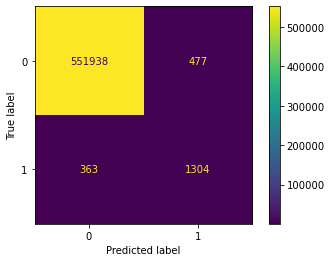

In [28]:
test_model(arbre,X_train1,X_test1,y_train1,y_test1)

In [29]:
predictions_simple0=arbre.predict(X_test1)

In [30]:
métriques(predictions_simple0,y_test1)

f1 score= 0.7563805104408353
precision= 0.7321729365524986
recall= 0.7822435512897421


#### modele regression logistique

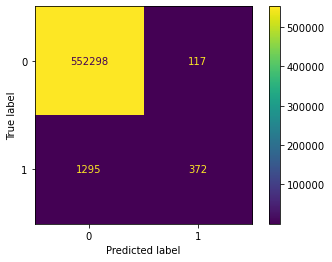

In [31]:
test_model(logistique,X_train1,X_test1,y_train1,y_test1)

In [32]:
predictions_simple1=logistique.predict(X_test1)

In [33]:
métriques(predictions_simple1,y_test1)

f1 score= 0.3450834879406308
precision= 0.7607361963190185
recall= 0.22315536892621476


#### modele  KNeighborsClassifier

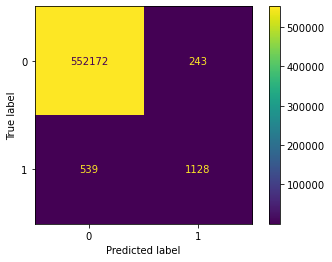

In [34]:
test_model(voisins,X_train1,X_test1,y_train1,y_test1)

In [35]:
predictions_simple2=voisins.predict(X_test1)

In [36]:
métriques(predictions_simple2,y_test1)

f1 score= 0.7425938117182358
precision= 0.8227571115973742
recall= 0.6766646670665867


**randomforest**

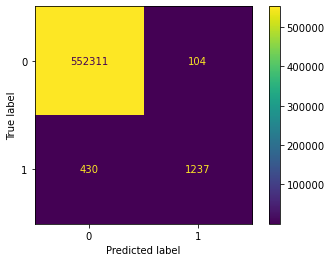

In [37]:
test_model(randomforest,X_train1,X_test1,y_train1,y_test1)

In [38]:
predictions_simple_randomf=randomforest.predict(X_test1)

In [39]:
métriques(predictions_simple_randomf,y_test1)

f1 score= 0.8224734042553192
precision= 0.9224459358687547
recall= 0.7420515896820636


**Xgboost**

[13:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


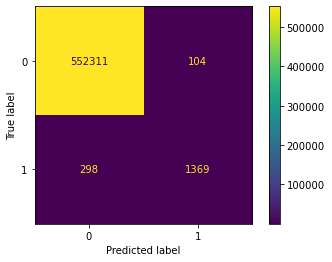

In [40]:
test_model(xgb,X_train1,X_test1,y_train1,y_test1)

In [41]:
predictions_simple_xgb=xgb.predict(X_test1)

In [42]:
métriques(predictions_simple_xgb,y_test1)

f1 score= 0.8719745222929937
precision= 0.9293957909029192
recall= 0.8212357528494301


**extreme_tree**

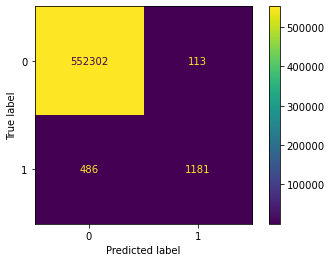

In [43]:
test_model(extreme_tree,X_train1,X_test1,y_train1,y_test1)

In [44]:
predictions_simple_ext_tree=extreme_tree.predict(X_test1)

In [45]:
métriques(predictions_simple_ext_tree,y_test1)

f1 score= 0.7977034785545423
precision= 0.9126738794435858
recall= 0.7084583083383323


**gradientboosting**

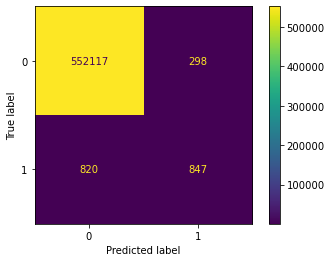

In [46]:
test_model(gradientboosting,X_train1,X_test1,y_train1,y_test1)

In [47]:
predictions_simple_grad_boost=gradientboosting.predict(X_test1)

In [48]:
métriques(predictions_simple_grad_boost,y_test1)

f1 score= 0.6024182076813656
precision= 0.7397379912663755
recall= 0.5080983803239352


**Catboost**

Learning rate set to 0.276388
0:	learn: 0.1138332	total: 603ms	remaining: 10m 1s
1:	learn: 0.0324308	total: 1.22s	remaining: 10m 10s
2:	learn: 0.0136515	total: 1.96s	remaining: 10m 49s
3:	learn: 0.0101015	total: 2.57s	remaining: 10m 40s
4:	learn: 0.0080935	total: 3.15s	remaining: 10m 26s
5:	learn: 0.0074127	total: 3.72s	remaining: 10m 17s
6:	learn: 0.0067963	total: 4.31s	remaining: 10m 11s
7:	learn: 0.0066147	total: 4.91s	remaining: 10m 8s
8:	learn: 0.0063812	total: 5.49s	remaining: 10m 4s
9:	learn: 0.0061858	total: 6.04s	remaining: 9m 57s
10:	learn: 0.0060872	total: 6.58s	remaining: 9m 51s
11:	learn: 0.0059491	total: 7.18s	remaining: 9m 51s
12:	learn: 0.0058393	total: 7.73s	remaining: 9m 46s
13:	learn: 0.0056814	total: 8.3s	remaining: 9m 44s
14:	learn: 0.0056023	total: 8.87s	remaining: 9m 42s
15:	learn: 0.0055619	total: 9.43s	remaining: 9m 39s
16:	learn: 0.0052694	total: 10s	remaining: 9m 39s
17:	learn: 0.0050010	total: 10.6s	remaining: 9m 36s
18:	learn: 0.0048581	total: 11.2s	remaini

157:	learn: 0.0023361	total: 1m 20s	remaining: 7m 8s
158:	learn: 0.0023342	total: 1m 21s	remaining: 7m 8s
159:	learn: 0.0023322	total: 1m 21s	remaining: 7m 8s
160:	learn: 0.0023289	total: 1m 22s	remaining: 7m 7s
161:	learn: 0.0023232	total: 1m 22s	remaining: 7m 6s
162:	learn: 0.0023216	total: 1m 23s	remaining: 7m 6s
163:	learn: 0.0023204	total: 1m 23s	remaining: 7m 5s
164:	learn: 0.0023185	total: 1m 24s	remaining: 7m 5s
165:	learn: 0.0023179	total: 1m 24s	remaining: 7m 4s
166:	learn: 0.0023161	total: 1m 24s	remaining: 7m 3s
167:	learn: 0.0023135	total: 1m 25s	remaining: 7m 3s
168:	learn: 0.0023075	total: 1m 25s	remaining: 7m 2s
169:	learn: 0.0023001	total: 1m 26s	remaining: 7m 1s
170:	learn: 0.0022908	total: 1m 26s	remaining: 7m 1s
171:	learn: 0.0022809	total: 1m 27s	remaining: 7m
172:	learn: 0.0022729	total: 1m 27s	remaining: 6m 59s
173:	learn: 0.0022631	total: 1m 28s	remaining: 6m 58s
174:	learn: 0.0022603	total: 1m 28s	remaining: 6m 58s
175:	learn: 0.0022530	total: 1m 29s	remaining:

311:	learn: 0.0018880	total: 2m 35s	remaining: 5m 42s
312:	learn: 0.0018835	total: 2m 35s	remaining: 5m 42s
313:	learn: 0.0018799	total: 2m 36s	remaining: 5m 41s
314:	learn: 0.0018777	total: 2m 36s	remaining: 5m 41s
315:	learn: 0.0018766	total: 2m 37s	remaining: 5m 40s
316:	learn: 0.0018731	total: 2m 37s	remaining: 5m 39s
317:	learn: 0.0018689	total: 2m 38s	remaining: 5m 39s
318:	learn: 0.0018668	total: 2m 38s	remaining: 5m 39s
319:	learn: 0.0018642	total: 2m 39s	remaining: 5m 38s
320:	learn: 0.0018632	total: 2m 39s	remaining: 5m 38s
321:	learn: 0.0018601	total: 2m 40s	remaining: 5m 37s
322:	learn: 0.0018587	total: 2m 40s	remaining: 5m 37s
323:	learn: 0.0018560	total: 2m 41s	remaining: 5m 36s
324:	learn: 0.0018552	total: 2m 41s	remaining: 5m 36s
325:	learn: 0.0018541	total: 2m 42s	remaining: 5m 35s
326:	learn: 0.0018491	total: 2m 42s	remaining: 5m 35s
327:	learn: 0.0018478	total: 2m 43s	remaining: 5m 34s
328:	learn: 0.0018473	total: 2m 43s	remaining: 5m 34s
329:	learn: 0.0018467	total:

464:	learn: 0.0016778	total: 3m 51s	remaining: 4m 26s
465:	learn: 0.0016747	total: 3m 51s	remaining: 4m 25s
466:	learn: 0.0016734	total: 3m 52s	remaining: 4m 25s
467:	learn: 0.0016715	total: 3m 52s	remaining: 4m 24s
468:	learn: 0.0016709	total: 3m 53s	remaining: 4m 24s
469:	learn: 0.0016706	total: 3m 53s	remaining: 4m 23s
470:	learn: 0.0016679	total: 3m 54s	remaining: 4m 23s
471:	learn: 0.0016667	total: 3m 54s	remaining: 4m 22s
472:	learn: 0.0016659	total: 3m 55s	remaining: 4m 22s
473:	learn: 0.0016631	total: 3m 55s	remaining: 4m 21s
474:	learn: 0.0016601	total: 3m 56s	remaining: 4m 21s
475:	learn: 0.0016586	total: 3m 56s	remaining: 4m 20s
476:	learn: 0.0016579	total: 3m 57s	remaining: 4m 20s
477:	learn: 0.0016557	total: 3m 57s	remaining: 4m 19s
478:	learn: 0.0016545	total: 3m 58s	remaining: 4m 19s
479:	learn: 0.0016539	total: 3m 58s	remaining: 4m 18s
480:	learn: 0.0016532	total: 3m 59s	remaining: 4m 18s
481:	learn: 0.0016526	total: 4m	remaining: 4m 17s
482:	learn: 0.0016510	total: 4m	

618:	learn: 0.0015178	total: 5m 10s	remaining: 3m 10s
619:	learn: 0.0015161	total: 5m 10s	remaining: 3m 10s
620:	learn: 0.0015140	total: 5m 11s	remaining: 3m 9s
621:	learn: 0.0015136	total: 5m 11s	remaining: 3m 9s
622:	learn: 0.0015130	total: 5m 12s	remaining: 3m 8s
623:	learn: 0.0015125	total: 5m 12s	remaining: 3m 8s
624:	learn: 0.0015121	total: 5m 13s	remaining: 3m 7s
625:	learn: 0.0015104	total: 5m 13s	remaining: 3m 7s
626:	learn: 0.0015103	total: 5m 13s	remaining: 3m 6s
627:	learn: 0.0015099	total: 5m 14s	remaining: 3m 6s
628:	learn: 0.0015086	total: 5m 14s	remaining: 3m 5s
629:	learn: 0.0015061	total: 5m 15s	remaining: 3m 5s
630:	learn: 0.0015060	total: 5m 15s	remaining: 3m 4s
631:	learn: 0.0015059	total: 5m 16s	remaining: 3m 4s
632:	learn: 0.0015049	total: 5m 16s	remaining: 3m 3s
633:	learn: 0.0015041	total: 5m 17s	remaining: 3m 3s
634:	learn: 0.0015035	total: 5m 17s	remaining: 3m 2s
635:	learn: 0.0015034	total: 5m 18s	remaining: 3m 2s
636:	learn: 0.0015031	total: 5m 18s	remainin

772:	learn: 0.0014012	total: 6m 29s	remaining: 1m 54s
773:	learn: 0.0013989	total: 6m 29s	remaining: 1m 53s
774:	learn: 0.0013985	total: 6m 30s	remaining: 1m 53s
775:	learn: 0.0013983	total: 6m 30s	remaining: 1m 52s
776:	learn: 0.0013979	total: 6m 31s	remaining: 1m 52s
777:	learn: 0.0013975	total: 6m 31s	remaining: 1m 51s
778:	learn: 0.0013970	total: 6m 32s	remaining: 1m 51s
779:	learn: 0.0013948	total: 6m 32s	remaining: 1m 50s
780:	learn: 0.0013945	total: 6m 33s	remaining: 1m 50s
781:	learn: 0.0013937	total: 6m 33s	remaining: 1m 49s
782:	learn: 0.0013933	total: 6m 34s	remaining: 1m 49s
783:	learn: 0.0013923	total: 6m 34s	remaining: 1m 48s
784:	learn: 0.0013920	total: 6m 35s	remaining: 1m 48s
785:	learn: 0.0013920	total: 6m 35s	remaining: 1m 47s
786:	learn: 0.0013919	total: 6m 35s	remaining: 1m 47s
787:	learn: 0.0013908	total: 6m 36s	remaining: 1m 46s
788:	learn: 0.0013901	total: 6m 36s	remaining: 1m 46s
789:	learn: 0.0013898	total: 6m 37s	remaining: 1m 45s
790:	learn: 0.0013896	total:

926:	learn: 0.0013037	total: 7m 40s	remaining: 36.3s
927:	learn: 0.0013031	total: 7m 41s	remaining: 35.8s
928:	learn: 0.0013025	total: 7m 41s	remaining: 35.3s
929:	learn: 0.0013014	total: 7m 42s	remaining: 34.8s
930:	learn: 0.0013000	total: 7m 42s	remaining: 34.3s
931:	learn: 0.0012997	total: 7m 43s	remaining: 33.8s
932:	learn: 0.0012994	total: 7m 43s	remaining: 33.3s
933:	learn: 0.0012977	total: 7m 44s	remaining: 32.8s
934:	learn: 0.0012969	total: 7m 44s	remaining: 32.3s
935:	learn: 0.0012967	total: 7m 45s	remaining: 31.8s
936:	learn: 0.0012954	total: 7m 45s	remaining: 31.3s
937:	learn: 0.0012953	total: 7m 46s	remaining: 30.8s
938:	learn: 0.0012943	total: 7m 46s	remaining: 30.3s
939:	learn: 0.0012933	total: 7m 47s	remaining: 29.8s
940:	learn: 0.0012931	total: 7m 47s	remaining: 29.3s
941:	learn: 0.0012913	total: 7m 48s	remaining: 28.8s
942:	learn: 0.0012909	total: 7m 48s	remaining: 28.3s
943:	learn: 0.0012902	total: 7m 49s	remaining: 27.8s
944:	learn: 0.0012899	total: 7m 49s	remaining:

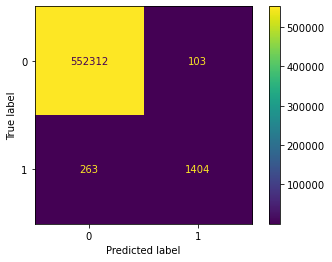

In [90]:
test_model(cad,X_train1,X_test1,y_train1,y_test1)

In [91]:
predictions_cad_simple=cad.predict(X_test1)

In [92]:
métriques(predictions_cad_simple,y_test1)

f1 score= 0.8846880907372401
precision= 0.9316522893165229
recall= 0.8422315536892622


In [93]:
roc_auc_score(y_test1,predictions_cad_simple)

0.9210225498323307

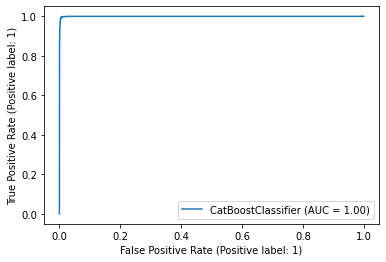

In [96]:
plot_roc_curve(cad,X_test1,y_test1)

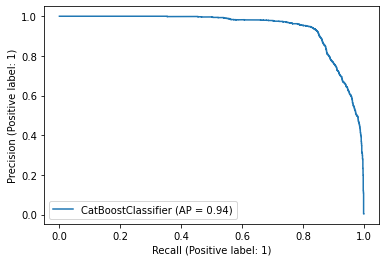

In [98]:
plot_precision_recall_curve(cad,X_test1,y_test1)

**ADAboost**

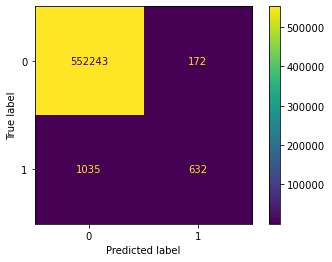

In [52]:
test_model(ADAboost,X_train1,X_test1,y_train1,y_test1)

In [53]:
predictions_ADA_simple=ADAboost.predict(X_test1)

In [54]:
métriques(predictions_ADA_simple,y_test1)

f1 score= 0.5115337919870497
precision= 0.7860696517412935
recall= 0.379124175164967


### Recap


Nos meilleurs modèles actuels sont XGBoost et CatBoost. Pour que le recall de chacun de nos modèle soit plus élevé, nous allon réequilibré nos données avec des algorithmes SMOTE, SMOTE_ENN et SMOTE_Tomek

# Modèles avec réequilibrage de nos données

Après avoir obtenu ces clarifications nous allons effectuer un preprocessing plus approfondie

Dans cette section, nous allons refaire une copie du dataset initial, appliquer plusieurs types de transformations              (SMOTE,SMOTE_ENN,SMOTE_Tomek)

###  définitions des fonctions preprocessing avec un SMOTE

**(les détails de chacunes des sous-fonctions utilisés sont au début de la section 'preprocessing')**

**Les fonction ci-dessous nous rendent toutes un trainset et un testset séparé de leur target**

**SMOTE simple:**

In [11]:
dataset1=fraudes.copy()

In [12]:
def preprocess_SMOTE(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
    X_res_train, y_res_train = algo_smote(X_train4, y_train4)
    
    return X_res_train, y_res_train,X_test4,y_test4

**SMOTE_ENN**

In [13]:
dataset2=fraudes.copy()

In [14]:
def preprocess_ENN(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
    X_res_train, y_res_train = algo_smote_ENN(X_train4, y_train4)
    
    return X_res_train, y_res_train,X_test4,y_test4

**SMOTE_Tomek**

In [15]:
dataset3=fraudes.copy()

In [16]:
def preprocess_Tomek(df):
    
    df=retirer_transactions(df)
    df=enlever_colonnes(df)
    df=encoder(df)
    df=scaler(df)
    
    
    X=df.drop('isFraud',axis=1)
    y=df['isFraud']
    
    X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size = 0.2, random_state = 30) 
    
    X_res_train, y_res_train = algo_smote_Tomek(X_train4, y_train4)
    
    return X_res_train, y_res_train,X_test4,y_test4

#### Lancement des preprocess et recuperation des variables 


In [19]:
X_res_train, y_res_train,X_test4,y_test4=preprocess_SMOTE(dataset1)

In [20]:
X_res_train2, y_res_train2,X_test5,y_test5=preprocess_ENN(dataset2)

In [21]:
X_res_train3, y_res_train3,X_test6,y_test6=preprocess_Tomek(dataset3)

### Enregistrement des données preprocessés dans des pickles

On enregistre les données preprocessées avec 'preprocess_ENN' et 'preprocess_Tomek', étant donné que les algo ci-dessus mettent beaucoup de temps 

preprocess sans SMOTE

In [31]:
with open('X_train1', 'wb') as f1:
    pickle.dump(X_train1, f1)
with open('y_train1', 'wb') as f2:
    pickle.dump(y_train1, f2)
with open('X_test1', 'wb') as f3:
    pickle.dump(X_test1, f3)
with open('y_test1', 'wb') as f4:
    pickle.dump(y_test1, f4)

preprocess SMOTE simple

In [32]:
with open('X_res_train', 'wb') as f1:
    pickle.dump(X_res_train, f1)
with open('y_res_train', 'wb') as f2:
    pickle.dump(y_res_train, f2)
with open('X_test4', 'wb') as f3:
    pickle.dump(X_test4, f3)
with open('y_test4', 'wb') as f4:
    pickle.dump(y_test4, f4)

preprocess_ENN

In [33]:
with open('X_res_train2', 'wb') as f1:
    pickle.dump(X_res_train2, f1)
with open('y_res_train2', 'wb') as f2:
    pickle.dump(y_res_train2, f2)
with open('X_test5', 'wb') as f3:
    pickle.dump(X_test5, f3)
with open('y_test5', 'wb') as f4:
    pickle.dump(y_test5, f4)

puis preprocess_Tomek

In [34]:
with open('X_res_train3', 'wb') as f5:
    pickle.dump(X_res_train3, f5)
with open('y_res_train3', 'wb') as f6:
    pickle.dump(y_res_train3, f6)
with open('X_test6', 'wb') as f8:
    pickle.dump(X_test6, f8)   
with open('y_test6', 'wb') as f7:
    pickle.dump(y_test6, f7)

### Modèles  avec le 'preprocess_SMOTE'

Voià à quoi ressemble notre **X_res_train** après avoir appliqué ce preprocessing:

In [33]:
X_res_train

,amount,oldbalanceOrg,oldbalanceDest,heures,is_Cash_OUT
0,-0.330823,-0.009806,2.448135,0.857143,1
1,0.097249,-0.009806,0.552595,-1.000000,0
2,-0.365078,2.055813,-0.345628,0.285714,0
3,-0.348095,2.787214,0.010460,-0.285714,0
4,0.636678,0.569218,-0.075947,0.428571,0
...,...,...,...,...,...
4419557,4.964716,41.363619,-0.345628,0.142857,1
4419558,5.929925,48.333024,-0.345628,-0.554052,1
4419559,9.159042,71.649259,-0.345628,-1.939502,1
4419560,1.429187,15.834894,-0.345628,-1.774446,1


On voit que le nombre de ligne à presque doublé ( de 5 à plus de 10 millions), cela est dû à notre algorithme Smote qui à donc rajouté suffisamment de transaction frauduleuses artificielles pour qu'il y en ait autant que de transactions non-frauduleuses.

On peut retester le modèle

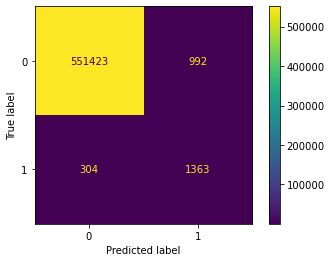

In [26]:
test_model(arbre,X_res_train,X_test4, y_res_train,y_test4)

In [27]:
predictions6=arbre.predict(X_test4)

In [28]:
métriques(predictions6,y_test4)

f1 score= 0.6777722526106414
precision= 0.5787685774946921
recall= 0.8176364727054589


**Application d'un SGD Classifier preprocessé**

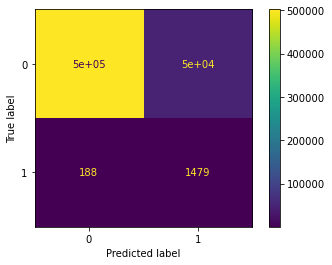

In [41]:
test_model(sgd,X_res_train,X_test4, y_res_train,y_test4)

In [42]:
predictions_sgd=sgd.predict(X_test4)

In [43]:
métriques(predictions_sgd,y_test4)

f1 score= 0.055687337625663615
precision= 0.028745796971876153
recall= 0.8872225554889022


**Avec une regression logistique**

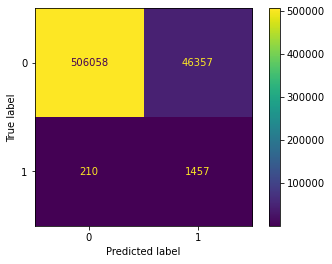

In [44]:
test_model(logistique,X_res_train,X_test4, y_res_train,y_test4)

In [45]:
predictions_logistique=logistique.predict(X_test4)

In [46]:
métriques(predictions_logistique,y_test4)

f1 score= 0.058891291606879406
precision= 0.030472246622328187
recall= 0.8740251949610078


precision trop faible (0,03)

#### Forêt d'arbres de decisions ( 100 arbres)
tourne pendant environ 1h

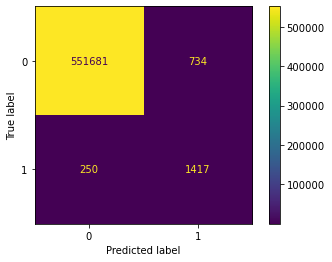

In [47]:
test_model(randomforest,X_res_train,X_test4, y_res_train,y_test4) 

In [48]:
predictions_forêt=randomforest.predict(X_test4)

In [49]:
métriques(predictions_forêt,y_test4)

f1 score= 0.7422734415924568
precision= 0.6587633658763365
recall= 0.8500299940011997


**extreme tree**

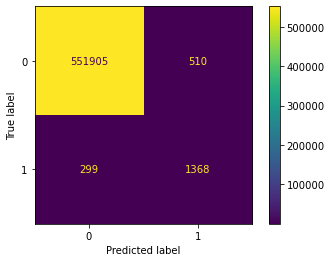

In [55]:
test_model(extreme_tree,X_res_train,X_test4, y_res_train,y_test4)

In [56]:
predictions_simple_ext_tree=extreme_tree.predict(X_test4)

In [57]:
métriques(predictions_simple_ext_tree,y_test4)

f1 score= 0.7717912552891396
precision= 0.7284345047923323
recall= 0.8206358728254349


**xgb**

[20:04:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


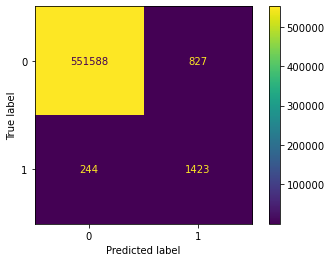

In [58]:
test_model(xgb,X_res_train,X_test4, y_res_train,y_test4)

In [59]:
predictions_xgb=xgb.predict(X_test4)

In [60]:
métriques(predictions_xgb,y_test4)

f1 score= 0.726576461577738
precision= 0.6324444444444445
recall= 0.853629274145171


**voisins**

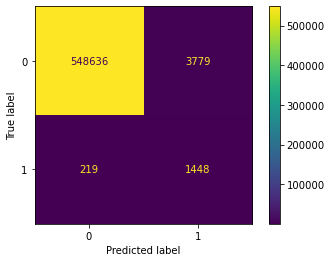

In [61]:
test_model(voisins,X_res_train,X_test4, y_res_train,y_test4)

In [62]:
predictions_voisins=voisins.predict(X_test4)

In [63]:
métriques(predictions_voisins,y_test4)

f1 score= 0.4200754279083261
precision= 0.27702314903386266
recall= 0.8686262747450509


**Modele ADAboost** 

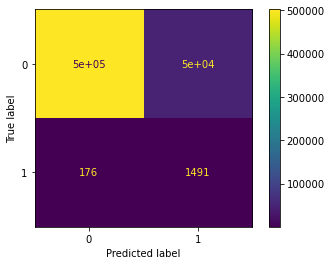

In [64]:
test_model(ADAboost,X_res_train,X_test4, y_res_train,y_test4)

In [65]:
predictions_ADA=ADAboost.predict(X_test4)

In [66]:
métriques(predictions_ADA,y_test4)

f1 score= 0.0560642238056741
precision= 0.02893909397927099
recall= 0.8944211157768446


**gradientboosting**

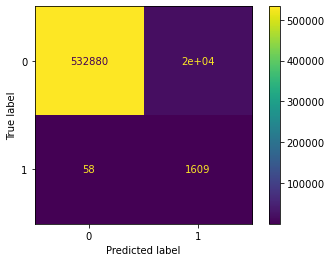

In [77]:
test_model(gradientboosting,X_res_train,X_test4, y_res_train,y_test4)

In [78]:
predictions_gradient_boost=gradientboosting.predict(X_test4)

In [79]:
métriques(predictions_gradient_boost,y_test4)

f1 score= 0.1410722896848012
precision= 0.07609723798713583
recall= 0.9652069586082783


Learning rate set to 0.371117
0:	learn: 0.2555110	total: 883ms	remaining: 14m 42s
1:	learn: 0.1675772	total: 1.76s	remaining: 14m 37s
2:	learn: 0.1288385	total: 2.67s	remaining: 14m 47s
3:	learn: 0.1142571	total: 3.57s	remaining: 14m 50s
4:	learn: 0.1033205	total: 4.55s	remaining: 15m 6s
5:	learn: 0.0967358	total: 5.63s	remaining: 15m 32s
6:	learn: 0.0898907	total: 6.54s	remaining: 15m 27s
7:	learn: 0.0847037	total: 7.47s	remaining: 15m 26s
8:	learn: 0.0812586	total: 8.42s	remaining: 15m 26s
9:	learn: 0.0758037	total: 9.39s	remaining: 15m 29s
10:	learn: 0.0726695	total: 10.3s	remaining: 15m 28s
11:	learn: 0.0671886	total: 11.3s	remaining: 15m 28s
12:	learn: 0.0642595	total: 12.2s	remaining: 15m 26s
13:	learn: 0.0621006	total: 13.1s	remaining: 15m 20s
14:	learn: 0.0597652	total: 14s	remaining: 15m 20s
15:	learn: 0.0574328	total: 14.9s	remaining: 15m 18s
16:	learn: 0.0548705	total: 15.9s	remaining: 15m 18s
17:	learn: 0.0531943	total: 16.8s	remaining: 15m 17s
18:	learn: 0.0513599	total: 1

153:	learn: 0.0116877	total: 2m 24s	remaining: 13m 15s
154:	learn: 0.0116876	total: 2m 25s	remaining: 13m 12s
155:	learn: 0.0116574	total: 2m 26s	remaining: 13m 11s
156:	learn: 0.0116571	total: 2m 27s	remaining: 13m 9s
157:	learn: 0.0116320	total: 2m 27s	remaining: 13m 8s
158:	learn: 0.0116106	total: 2m 29s	remaining: 13m 9s
159:	learn: 0.0115870	total: 2m 30s	remaining: 13m 8s
160:	learn: 0.0115737	total: 2m 31s	remaining: 13m 7s
161:	learn: 0.0114794	total: 2m 32s	remaining: 13m 6s
162:	learn: 0.0114311	total: 2m 33s	remaining: 13m 5s
163:	learn: 0.0114198	total: 2m 33s	remaining: 13m 4s
164:	learn: 0.0114144	total: 2m 34s	remaining: 13m 3s
165:	learn: 0.0113507	total: 2m 35s	remaining: 13m 2s
166:	learn: 0.0112855	total: 2m 36s	remaining: 13m 1s
167:	learn: 0.0112630	total: 2m 37s	remaining: 12m 59s
168:	learn: 0.0111342	total: 2m 38s	remaining: 12m 58s
169:	learn: 0.0110937	total: 2m 39s	remaining: 12m 57s
170:	learn: 0.0110227	total: 2m 40s	remaining: 12m 56s
171:	learn: 0.0109480

304:	learn: 0.0093062	total: 4m 27s	remaining: 10m 9s
305:	learn: 0.0093062	total: 4m 28s	remaining: 10m 8s
306:	learn: 0.0093062	total: 4m 29s	remaining: 10m 7s
307:	learn: 0.0093062	total: 4m 29s	remaining: 10m 6s
308:	learn: 0.0093062	total: 4m 30s	remaining: 10m 5s
309:	learn: 0.0093061	total: 4m 31s	remaining: 10m 3s
310:	learn: 0.0093061	total: 4m 31s	remaining: 10m 2s
311:	learn: 0.0093059	total: 4m 32s	remaining: 10m 1s
312:	learn: 0.0093058	total: 4m 33s	remaining: 9m 59s
313:	learn: 0.0093058	total: 4m 34s	remaining: 9m 58s
314:	learn: 0.0093058	total: 4m 34s	remaining: 9m 57s
315:	learn: 0.0093058	total: 4m 35s	remaining: 9m 56s
316:	learn: 0.0093058	total: 4m 36s	remaining: 9m 54s
317:	learn: 0.0093058	total: 4m 36s	remaining: 9m 53s
318:	learn: 0.0093058	total: 4m 37s	remaining: 9m 52s
319:	learn: 0.0093058	total: 4m 38s	remaining: 9m 51s
320:	learn: 0.0093057	total: 4m 39s	remaining: 9m 50s
321:	learn: 0.0093057	total: 4m 39s	remaining: 9m 49s
322:	learn: 0.0093057	total:

457:	learn: 0.0090745	total: 6m 20s	remaining: 7m 30s
458:	learn: 0.0090745	total: 6m 21s	remaining: 7m 29s
459:	learn: 0.0090745	total: 6m 21s	remaining: 7m 28s
460:	learn: 0.0090744	total: 6m 22s	remaining: 7m 27s
461:	learn: 0.0090744	total: 6m 23s	remaining: 7m 26s
462:	learn: 0.0090744	total: 6m 23s	remaining: 7m 25s
463:	learn: 0.0090744	total: 6m 24s	remaining: 7m 24s
464:	learn: 0.0090744	total: 6m 25s	remaining: 7m 23s
465:	learn: 0.0090744	total: 6m 26s	remaining: 7m 22s
466:	learn: 0.0090743	total: 6m 26s	remaining: 7m 21s
467:	learn: 0.0090743	total: 6m 27s	remaining: 7m 20s
468:	learn: 0.0090743	total: 6m 28s	remaining: 7m 19s
469:	learn: 0.0090742	total: 6m 29s	remaining: 7m 19s
470:	learn: 0.0090742	total: 6m 30s	remaining: 7m 18s
471:	learn: 0.0090741	total: 6m 30s	remaining: 7m 17s
472:	learn: 0.0090741	total: 6m 31s	remaining: 7m 16s
473:	learn: 0.0090741	total: 6m 32s	remaining: 7m 15s
474:	learn: 0.0090741	total: 6m 33s	remaining: 7m 14s
475:	learn: 0.0090740	total:

610:	learn: 0.0087732	total: 8m 16s	remaining: 5m 16s
611:	learn: 0.0087732	total: 8m 17s	remaining: 5m 15s
612:	learn: 0.0087731	total: 8m 18s	remaining: 5m 14s
613:	learn: 0.0087731	total: 8m 18s	remaining: 5m 13s
614:	learn: 0.0087731	total: 8m 19s	remaining: 5m 12s
615:	learn: 0.0087731	total: 8m 20s	remaining: 5m 11s
616:	learn: 0.0087730	total: 8m 21s	remaining: 5m 11s
617:	learn: 0.0087729	total: 8m 22s	remaining: 5m 10s
618:	learn: 0.0087729	total: 8m 22s	remaining: 5m 9s
619:	learn: 0.0087729	total: 8m 23s	remaining: 5m 8s
620:	learn: 0.0087729	total: 8m 24s	remaining: 5m 7s
621:	learn: 0.0087728	total: 8m 24s	remaining: 5m 6s
622:	learn: 0.0087728	total: 8m 25s	remaining: 5m 5s
623:	learn: 0.0087728	total: 8m 26s	remaining: 5m 5s
624:	learn: 0.0087727	total: 8m 27s	remaining: 5m 4s
625:	learn: 0.0087726	total: 8m 28s	remaining: 5m 3s
626:	learn: 0.0087725	total: 8m 28s	remaining: 5m 2s
627:	learn: 0.0087725	total: 8m 29s	remaining: 5m 1s
628:	learn: 0.0087725	total: 8m 30s	re

763:	learn: 0.0084474	total: 10m 17s	remaining: 3m 10s
764:	learn: 0.0084473	total: 10m 17s	remaining: 3m 9s
765:	learn: 0.0084473	total: 10m 18s	remaining: 3m 8s
766:	learn: 0.0084473	total: 10m 19s	remaining: 3m 8s
767:	learn: 0.0084473	total: 10m 19s	remaining: 3m 7s
768:	learn: 0.0084473	total: 10m 20s	remaining: 3m 6s
769:	learn: 0.0084472	total: 10m 21s	remaining: 3m 5s
770:	learn: 0.0084472	total: 10m 21s	remaining: 3m 4s
771:	learn: 0.0084472	total: 10m 22s	remaining: 3m 3s
772:	learn: 0.0084472	total: 10m 23s	remaining: 3m 3s
773:	learn: 0.0084472	total: 10m 24s	remaining: 3m 2s
774:	learn: 0.0084472	total: 10m 24s	remaining: 3m 1s
775:	learn: 0.0084471	total: 10m 25s	remaining: 3m
776:	learn: 0.0084471	total: 10m 26s	remaining: 2m 59s
777:	learn: 0.0084402	total: 10m 27s	remaining: 2m 58s
778:	learn: 0.0084402	total: 10m 27s	remaining: 2m 58s
779:	learn: 0.0084402	total: 10m 29s	remaining: 2m 57s
780:	learn: 0.0084402	total: 10m 29s	remaining: 2m 56s
781:	learn: 0.0084402	tot

914:	learn: 0.0082339	total: 12m 4s	remaining: 1m 7s
915:	learn: 0.0082339	total: 12m 5s	remaining: 1m 6s
916:	learn: 0.0082339	total: 12m 6s	remaining: 1m 5s
917:	learn: 0.0082339	total: 12m 7s	remaining: 1m 4s
918:	learn: 0.0082339	total: 12m 7s	remaining: 1m 4s
919:	learn: 0.0082339	total: 12m 8s	remaining: 1m 3s
920:	learn: 0.0082339	total: 12m 9s	remaining: 1m 2s
921:	learn: 0.0082339	total: 12m 9s	remaining: 1m 1s
922:	learn: 0.0082339	total: 12m 10s	remaining: 1m
923:	learn: 0.0082339	total: 12m 10s	remaining: 1m
924:	learn: 0.0082339	total: 12m 11s	remaining: 59.3s
925:	learn: 0.0082339	total: 12m 12s	remaining: 58.5s
926:	learn: 0.0082339	total: 12m 12s	remaining: 57.7s
927:	learn: 0.0082339	total: 12m 13s	remaining: 56.9s
928:	learn: 0.0082339	total: 12m 14s	remaining: 56.1s
929:	learn: 0.0082339	total: 12m 14s	remaining: 55.3s
930:	learn: 0.0082339	total: 12m 15s	remaining: 54.5s
931:	learn: 0.0082339	total: 12m 15s	remaining: 53.7s
932:	learn: 0.0082339	total: 12m 16s	remai

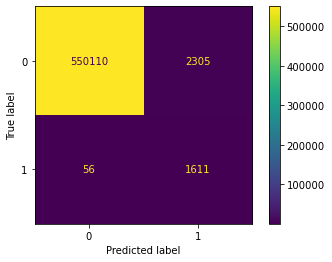

In [145]:
test_model(cad,X_res_train,X_test4, y_res_train,y_test4)

In [146]:
predictions_cad=cad.predict(X_test4)

In [147]:
métriques(predictions_cad,y_test4)

f1 score= 0.5771090811391726
precision= 0.4113891726251277
recall= 0.9664067186562687


Pour tout nos modèles, on constate bien que la précision a baisser au profit du recall

Le Catboost et le Xgboost ont des précisions qui passent de 0,842 à 0,411 (respectivement de 0,929 à 0.632) 
et un recall qui passe de 0,842 à 0.966 (resp: de 0,821 à 0.853)


### Modèles avec SMOTE_ENN:

In [26]:
y_test5.value_counts()

0    552415
1      1667
Name: isFraud, dtype: int64

La quantité de ligne encore un peu baissée après avoir appliquer un ENN

**arbre de decision**

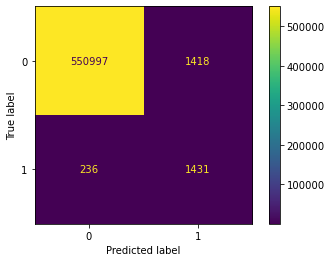

In [57]:
test_model(arbre,X_res_train2,X_test5, y_res_train2,y_test5)

In [58]:
predictions_arbre_ENN=arbre.predict(X_test5)

In [59]:
métriques(predictions_arbre_ENN,y_test5)

f1 score= 0.6337466784765279
precision= 0.5022815022815023
recall= 0.8584283143371326


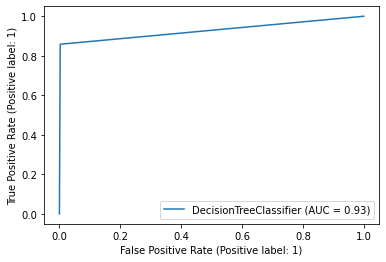

In [60]:
plot_roc_curve(arbre,X_test5,y_test5)

**forêt d'arbres de decisions**

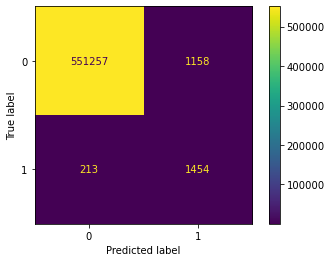

In [83]:
test_model(randomforest,X_res_train2,X_test5, y_res_train2,y_test5)

In [84]:
predictions_foret_ENN=randomforest.predict(X_test5)

In [85]:
métriques(predictions_foret_ENN,y_test5)

f1 score= 0.6795980369245149
precision= 0.5566615620214395
recall= 0.8722255548890222


**gradientboosting**

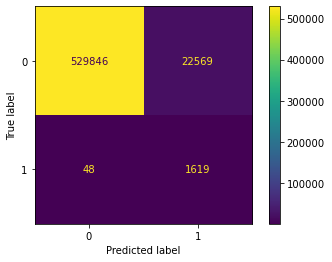

In [86]:
test_model(gradientboosting,X_res_train2,X_test5, y_res_train2,y_test5)

In [87]:
predictions_gradient_ENN=gradientboosting.predict(X_test5)

In [88]:
métriques(predictions_gradient_ENN,y_test5)

f1 score= 0.1252368980854767
precision= 0.06693401686786836
recall= 0.9712057588482303


**extratreeclassifier**

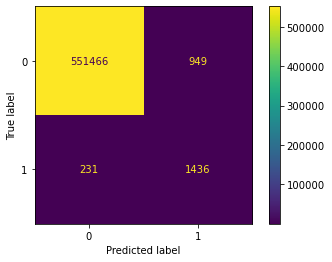

In [89]:
test_model(extreme_tree,X_res_train2,X_test5, y_res_train2,y_test5)

In [90]:
predictions_extree_ENN=extreme_tree.predict(X_test5)

In [91]:
métriques(predictions_extree_ENN,y_test5)

f1 score= 0.7087857847976308
precision= 0.6020964360587002
recall= 0.8614277144571085


**xgb**

[23:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


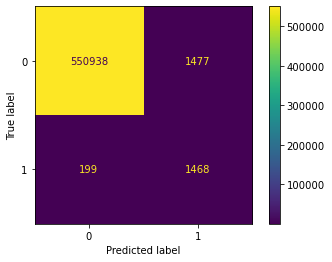

In [92]:
test_model(xgb,X_res_train2,X_test5, y_res_train2,y_test5)

In [93]:
predictions_xgb_ENN=xgb.predict(X_test5)

In [94]:
métriques(predictions_xgb_ENN,y_test5)

f1 score= 0.6366001734605377
precision= 0.49847198641765705
recall= 0.880623875224955


**voisins**

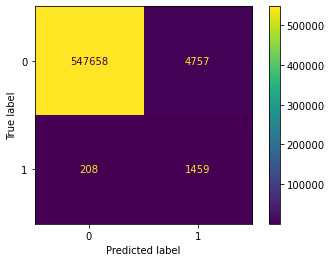

In [95]:
test_model(voisins,X_res_train2,X_test5, y_res_train2,y_test5)

In [96]:
predictions_voisins_ENN=voisins.predict(X_test5)

In [97]:
métriques(predictions_voisins_ENN,y_test5)

f1 score= 0.3701636432830141
precision= 0.2347168597168597
recall= 0.8752249550089982


**adaboost**

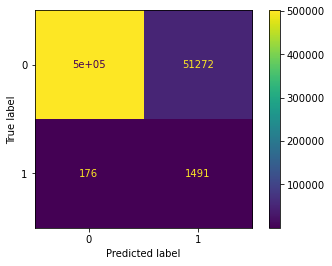

In [98]:
test_model(ADAboost,X_res_train2,X_test5, y_res_train2,y_test5)

In [99]:
predictions_ADA_ENN=ADAboost.predict(X_test5)

In [100]:
métriques(predictions_ADA_ENN,y_test5)

f1 score= 0.054785963623002025
precision= 0.028258438678619487
recall= 0.8944211157768446


**regression logistique**

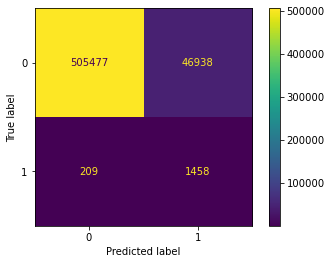

In [134]:
test_model(logistique,X_res_train2,X_test5, y_res_train2,y_test5)

In [135]:
predictions_logistique_ENN=logistique.predict(X_test5)

In [136]:
métriques(predictions_logistique_ENN,y_test5)

f1 score= 0.05824660927231688
precision= 0.03012645673196132
recall= 0.874625074985003


Learning rate set to 0.370461
0:	learn: 0.2647715	total: 1s	remaining: 16m 44s
1:	learn: 0.1567675	total: 1.95s	remaining: 16m 15s
2:	learn: 0.1207646	total: 2.88s	remaining: 15m 56s
3:	learn: 0.1048898	total: 3.7s	remaining: 15m 21s
4:	learn: 0.0955510	total: 4.45s	remaining: 14m 46s
5:	learn: 0.0888435	total: 5.28s	remaining: 14m 34s
6:	learn: 0.0859920	total: 6.11s	remaining: 14m 27s
7:	learn: 0.0804631	total: 6.97s	remaining: 14m 24s
8:	learn: 0.0763360	total: 7.87s	remaining: 14m 26s
9:	learn: 0.0737735	total: 8.72s	remaining: 14m 23s
10:	learn: 0.0708857	total: 9.57s	remaining: 14m 20s
11:	learn: 0.0657238	total: 10.4s	remaining: 14m 19s
12:	learn: 0.0628247	total: 11.3s	remaining: 14m 18s
13:	learn: 0.0609287	total: 12.1s	remaining: 14m 14s
14:	learn: 0.0578558	total: 13s	remaining: 14m 13s
15:	learn: 0.0557584	total: 14s	remaining: 14m 21s
16:	learn: 0.0534745	total: 15.1s	remaining: 14m 33s
17:	learn: 0.0491879	total: 16s	remaining: 14m 32s
18:	learn: 0.0468682	total: 16.8s	re

154:	learn: 0.0084926	total: 2m 24s	remaining: 13m 8s
155:	learn: 0.0084111	total: 2m 25s	remaining: 13m 7s
156:	learn: 0.0083461	total: 2m 26s	remaining: 13m 7s
157:	learn: 0.0083228	total: 2m 27s	remaining: 13m 5s
158:	learn: 0.0083014	total: 2m 28s	remaining: 13m 3s
159:	learn: 0.0082730	total: 2m 29s	remaining: 13m 2s
160:	learn: 0.0082470	total: 2m 29s	remaining: 13m 1s
161:	learn: 0.0082080	total: 2m 30s	remaining: 13m
162:	learn: 0.0081835	total: 2m 31s	remaining: 12m 59s
163:	learn: 0.0081548	total: 2m 32s	remaining: 12m 58s
164:	learn: 0.0081501	total: 2m 33s	remaining: 12m 56s
165:	learn: 0.0081079	total: 2m 34s	remaining: 12m 55s
166:	learn: 0.0080590	total: 2m 35s	remaining: 12m 54s
167:	learn: 0.0080182	total: 2m 36s	remaining: 12m 53s
168:	learn: 0.0079754	total: 2m 37s	remaining: 12m 52s
169:	learn: 0.0079422	total: 2m 38s	remaining: 12m 52s
170:	learn: 0.0079192	total: 2m 39s	remaining: 12m 51s
171:	learn: 0.0078830	total: 2m 40s	remaining: 12m 50s
172:	learn: 0.0078409

305:	learn: 0.0060760	total: 4m 31s	remaining: 10m 15s
306:	learn: 0.0060536	total: 4m 32s	remaining: 10m 15s
307:	learn: 0.0060535	total: 4m 33s	remaining: 10m 13s
308:	learn: 0.0060534	total: 4m 33s	remaining: 10m 12s
309:	learn: 0.0060397	total: 4m 34s	remaining: 10m 11s
310:	learn: 0.0060396	total: 4m 35s	remaining: 10m 10s
311:	learn: 0.0060216	total: 4m 36s	remaining: 10m 9s
312:	learn: 0.0060215	total: 4m 37s	remaining: 10m 8s
313:	learn: 0.0060215	total: 4m 37s	remaining: 10m 6s
314:	learn: 0.0060213	total: 4m 38s	remaining: 10m 5s
315:	learn: 0.0060212	total: 4m 39s	remaining: 10m 4s
316:	learn: 0.0060212	total: 4m 39s	remaining: 10m 2s
317:	learn: 0.0060211	total: 4m 40s	remaining: 10m 1s
318:	learn: 0.0060192	total: 4m 41s	remaining: 10m
319:	learn: 0.0060192	total: 4m 41s	remaining: 9m 58s
320:	learn: 0.0060192	total: 4m 42s	remaining: 9m 57s
321:	learn: 0.0060192	total: 4m 43s	remaining: 9m 56s
322:	learn: 0.0060192	total: 4m 43s	remaining: 9m 54s
323:	learn: 0.0060192	tot

458:	learn: 0.0055216	total: 6m 28s	remaining: 7m 38s
459:	learn: 0.0055216	total: 6m 29s	remaining: 7m 36s
460:	learn: 0.0055216	total: 6m 29s	remaining: 7m 35s
461:	learn: 0.0055216	total: 6m 30s	remaining: 7m 34s
462:	learn: 0.0055215	total: 6m 31s	remaining: 7m 33s
463:	learn: 0.0055215	total: 6m 32s	remaining: 7m 32s
464:	learn: 0.0055215	total: 6m 32s	remaining: 7m 31s
465:	learn: 0.0055215	total: 6m 33s	remaining: 7m 30s
466:	learn: 0.0055215	total: 6m 34s	remaining: 7m 29s
467:	learn: 0.0055215	total: 6m 34s	remaining: 7m 28s
468:	learn: 0.0055214	total: 6m 35s	remaining: 7m 27s
469:	learn: 0.0055214	total: 6m 36s	remaining: 7m 26s
470:	learn: 0.0055213	total: 6m 36s	remaining: 7m 25s
471:	learn: 0.0055213	total: 6m 37s	remaining: 7m 24s
472:	learn: 0.0055213	total: 6m 38s	remaining: 7m 23s
473:	learn: 0.0055081	total: 6m 39s	remaining: 7m 22s
474:	learn: 0.0054818	total: 6m 40s	remaining: 7m 22s
475:	learn: 0.0054815	total: 6m 40s	remaining: 7m 21s
476:	learn: 0.0054813	total:

611:	learn: 0.0053707	total: 8m 18s	remaining: 5m 16s
612:	learn: 0.0053707	total: 8m 19s	remaining: 5m 15s
613:	learn: 0.0053707	total: 8m 20s	remaining: 5m 14s
614:	learn: 0.0053707	total: 8m 20s	remaining: 5m 13s
615:	learn: 0.0053707	total: 8m 21s	remaining: 5m 12s
616:	learn: 0.0053707	total: 8m 22s	remaining: 5m 11s
617:	learn: 0.0053707	total: 8m 23s	remaining: 5m 11s
618:	learn: 0.0053707	total: 8m 23s	remaining: 5m 10s
619:	learn: 0.0053707	total: 8m 24s	remaining: 5m 9s
620:	learn: 0.0053707	total: 8m 25s	remaining: 5m 8s
621:	learn: 0.0053707	total: 8m 26s	remaining: 5m 7s
622:	learn: 0.0053707	total: 8m 26s	remaining: 5m 6s
623:	learn: 0.0053707	total: 8m 27s	remaining: 5m 5s
624:	learn: 0.0053707	total: 8m 28s	remaining: 5m 4s
625:	learn: 0.0053707	total: 8m 28s	remaining: 5m 3s
626:	learn: 0.0053707	total: 8m 29s	remaining: 5m 3s
627:	learn: 0.0053707	total: 8m 30s	remaining: 5m 2s
628:	learn: 0.0053707	total: 8m 31s	remaining: 5m 1s
629:	learn: 0.0053707	total: 8m 31s	re

764:	learn: 0.0053393	total: 10m 5s	remaining: 3m 6s
765:	learn: 0.0053393	total: 10m 6s	remaining: 3m 5s
766:	learn: 0.0053393	total: 10m 7s	remaining: 3m 4s
767:	learn: 0.0053393	total: 10m 7s	remaining: 3m 3s
768:	learn: 0.0053392	total: 10m 8s	remaining: 3m 2s
769:	learn: 0.0053392	total: 10m 9s	remaining: 3m 2s
770:	learn: 0.0053392	total: 10m 10s	remaining: 3m 1s
771:	learn: 0.0053292	total: 10m 10s	remaining: 3m
772:	learn: 0.0053292	total: 10m 11s	remaining: 2m 59s
773:	learn: 0.0053220	total: 10m 12s	remaining: 2m 58s
774:	learn: 0.0053219	total: 10m 13s	remaining: 2m 57s
775:	learn: 0.0053219	total: 10m 13s	remaining: 2m 57s
776:	learn: 0.0053219	total: 10m 14s	remaining: 2m 56s
777:	learn: 0.0053219	total: 10m 15s	remaining: 2m 55s
778:	learn: 0.0053219	total: 10m 15s	remaining: 2m 54s
779:	learn: 0.0053219	total: 10m 16s	remaining: 2m 53s
780:	learn: 0.0053219	total: 10m 17s	remaining: 2m 53s
781:	learn: 0.0053219	total: 10m 17s	remaining: 2m 52s
782:	learn: 0.0053219	total

914:	learn: 0.0052770	total: 11m 53s	remaining: 1m 6s
915:	learn: 0.0052770	total: 11m 53s	remaining: 1m 5s
916:	learn: 0.0052770	total: 11m 54s	remaining: 1m 4s
917:	learn: 0.0052770	total: 11m 55s	remaining: 1m 3s
918:	learn: 0.0052769	total: 11m 55s	remaining: 1m 3s
919:	learn: 0.0052769	total: 11m 56s	remaining: 1m 2s
920:	learn: 0.0052769	total: 11m 57s	remaining: 1m 1s
921:	learn: 0.0052767	total: 11m 57s	remaining: 1m
922:	learn: 0.0052767	total: 11m 58s	remaining: 60s
923:	learn: 0.0052766	total: 11m 59s	remaining: 59.2s
924:	learn: 0.0052765	total: 12m	remaining: 58.4s
925:	learn: 0.0052765	total: 12m	remaining: 57.6s
926:	learn: 0.0052765	total: 12m 1s	remaining: 56.8s
927:	learn: 0.0052765	total: 12m 2s	remaining: 56s
928:	learn: 0.0052763	total: 12m 2s	remaining: 55.2s
929:	learn: 0.0052763	total: 12m 3s	remaining: 54.5s
930:	learn: 0.0052763	total: 12m 4s	remaining: 53.7s
931:	learn: 0.0052763	total: 12m 5s	remaining: 52.9s
932:	learn: 0.0052762	total: 12m 5s	remaining: 52

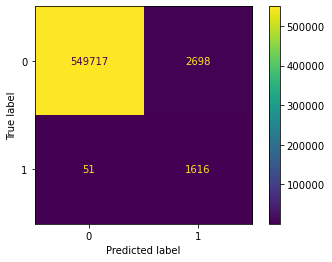

In [142]:
test_model(cad,X_res_train2,X_test5, y_res_train2,y_test5)

In [143]:
predictions_cad_ENN=cad.predict(X_test6)

In [144]:
métriques(predictions_cad_ENN,y_test6)

f1 score= 0.540377863233573
precision= 0.37459434399629116
recall= 0.9694061187762447


Résultats assez semblable en rajoutant un algorithme ENN

### Modèles avec SMOTE_Tomek:

#### forêt

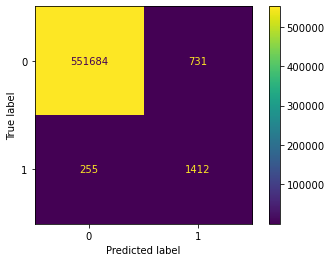

In [104]:
test_model(randomforest,X_res_train3,X_test6, y_res_train3,y_test6)

In [105]:
predictions_foret_tomek=randomforest.predict(X_test6)

In [106]:
métriques(predictions_foret_tomek,y_test6)

f1 score= 0.7412073490813649
precision= 0.6588894073728419
recall= 0.8470305938812237


**XGBoostClassifier**

[00:17:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


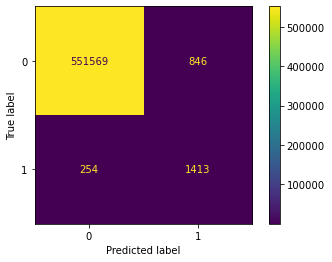

In [107]:
test_model(xgb,X_res_train3,X_test6, y_res_train3,y_test6)

In [108]:
predictions_xgb_ENN=xgb.predict(X_test6)

In [109]:
métriques(predictions_xgb_ENN,y_test6)

f1 score= 0.7198166072338257
precision= 0.6254980079681275
recall= 0.847630473905219


**CADBoost**

Learning rate set to 0.371095
0:	learn: 0.2623931	total: 944ms	remaining: 15m 42s
1:	learn: 0.1706294	total: 1.95s	remaining: 16m 10s
2:	learn: 0.1274531	total: 3.01s	remaining: 16m 41s
3:	learn: 0.1124704	total: 3.95s	remaining: 16m 23s
4:	learn: 0.1004182	total: 4.73s	remaining: 15m 41s
5:	learn: 0.0925505	total: 5.74s	remaining: 15m 50s
6:	learn: 0.0880215	total: 6.92s	remaining: 16m 21s
7:	learn: 0.0828370	total: 8.29s	remaining: 17m 7s
8:	learn: 0.0793152	total: 9.39s	remaining: 17m 14s
9:	learn: 0.0762488	total: 10.5s	remaining: 17m 16s
10:	learn: 0.0736415	total: 11.5s	remaining: 17m 16s
11:	learn: 0.0704648	total: 12.5s	remaining: 17m 12s
12:	learn: 0.0647838	total: 13.5s	remaining: 17m 8s
13:	learn: 0.0617461	total: 14.5s	remaining: 17m 4s
14:	learn: 0.0599812	total: 15.5s	remaining: 16m 59s
15:	learn: 0.0586135	total: 16.5s	remaining: 16m 51s
16:	learn: 0.0576337	total: 17.6s	remaining: 16m 56s
17:	learn: 0.0562265	total: 18.8s	remaining: 17m 6s
18:	learn: 0.0544408	total: 19

153:	learn: 0.0116255	total: 2m 32s	remaining: 14m
154:	learn: 0.0116252	total: 2m 33s	remaining: 13m 57s
155:	learn: 0.0116251	total: 2m 34s	remaining: 13m 55s
156:	learn: 0.0116045	total: 2m 35s	remaining: 13m 53s
157:	learn: 0.0115104	total: 2m 36s	remaining: 13m 51s
158:	learn: 0.0114576	total: 2m 37s	remaining: 13m 50s
159:	learn: 0.0114305	total: 2m 37s	remaining: 13m 48s
160:	learn: 0.0114214	total: 2m 38s	remaining: 13m 47s
161:	learn: 0.0113697	total: 2m 39s	remaining: 13m 46s
162:	learn: 0.0113397	total: 2m 40s	remaining: 13m 44s
163:	learn: 0.0112959	total: 2m 41s	remaining: 13m 43s
164:	learn: 0.0112777	total: 2m 42s	remaining: 13m 43s
165:	learn: 0.0112255	total: 2m 43s	remaining: 13m 42s
166:	learn: 0.0111575	total: 2m 44s	remaining: 13m 41s
167:	learn: 0.0111307	total: 2m 45s	remaining: 13m 39s
168:	learn: 0.0110848	total: 2m 46s	remaining: 13m 38s
169:	learn: 0.0109779	total: 2m 47s	remaining: 13m 37s
170:	learn: 0.0109054	total: 2m 48s	remaining: 13m 36s
171:	learn: 0.

304:	learn: 0.0093502	total: 4m 43s	remaining: 10m 46s
305:	learn: 0.0093502	total: 4m 44s	remaining: 10m 45s
306:	learn: 0.0093502	total: 4m 45s	remaining: 10m 44s
307:	learn: 0.0093502	total: 4m 46s	remaining: 10m 43s
308:	learn: 0.0093502	total: 4m 46s	remaining: 10m 41s
309:	learn: 0.0093502	total: 4m 47s	remaining: 10m 40s
310:	learn: 0.0093502	total: 4m 48s	remaining: 10m 38s
311:	learn: 0.0093502	total: 4m 48s	remaining: 10m 37s
312:	learn: 0.0093502	total: 4m 49s	remaining: 10m 36s
313:	learn: 0.0093502	total: 4m 50s	remaining: 10m 35s
314:	learn: 0.0093502	total: 4m 51s	remaining: 10m 34s
315:	learn: 0.0093502	total: 4m 52s	remaining: 10m 32s
316:	learn: 0.0093502	total: 4m 53s	remaining: 10m 31s
317:	learn: 0.0093502	total: 4m 53s	remaining: 10m 30s
318:	learn: 0.0093502	total: 4m 54s	remaining: 10m 28s
319:	learn: 0.0093502	total: 4m 55s	remaining: 10m 27s
320:	learn: 0.0093502	total: 4m 55s	remaining: 10m 26s
321:	learn: 0.0093502	total: 4m 56s	remaining: 10m 24s
322:	learn

457:	learn: 0.0091178	total: 6m 47s	remaining: 8m 2s
458:	learn: 0.0091177	total: 6m 48s	remaining: 8m
459:	learn: 0.0091177	total: 6m 48s	remaining: 7m 59s
460:	learn: 0.0091177	total: 6m 49s	remaining: 7m 58s
461:	learn: 0.0091177	total: 6m 50s	remaining: 7m 57s
462:	learn: 0.0091177	total: 6m 51s	remaining: 7m 56s
463:	learn: 0.0091177	total: 6m 51s	remaining: 7m 55s
464:	learn: 0.0091176	total: 6m 52s	remaining: 7m 54s
465:	learn: 0.0091176	total: 6m 53s	remaining: 7m 53s
466:	learn: 0.0091176	total: 6m 54s	remaining: 7m 52s
467:	learn: 0.0091176	total: 6m 54s	remaining: 7m 51s
468:	learn: 0.0091176	total: 6m 55s	remaining: 7m 50s
469:	learn: 0.0091176	total: 6m 56s	remaining: 7m 49s
470:	learn: 0.0091176	total: 6m 57s	remaining: 7m 48s
471:	learn: 0.0091176	total: 6m 58s	remaining: 7m 47s
472:	learn: 0.0091176	total: 6m 59s	remaining: 7m 47s
473:	learn: 0.0091176	total: 7m	remaining: 7m 46s
474:	learn: 0.0091176	total: 7m	remaining: 7m 45s
475:	learn: 0.0091176	total: 7m 1s	remain

610:	learn: 0.0083657	total: 8m 51s	remaining: 5m 38s
611:	learn: 0.0083657	total: 8m 52s	remaining: 5m 37s
612:	learn: 0.0083657	total: 8m 52s	remaining: 5m 36s
613:	learn: 0.0083657	total: 8m 53s	remaining: 5m 35s
614:	learn: 0.0083657	total: 8m 54s	remaining: 5m 34s
615:	learn: 0.0083657	total: 8m 55s	remaining: 5m 33s
616:	learn: 0.0083657	total: 8m 55s	remaining: 5m 32s
617:	learn: 0.0083657	total: 8m 56s	remaining: 5m 31s
618:	learn: 0.0083657	total: 8m 57s	remaining: 5m 30s
619:	learn: 0.0083657	total: 8m 57s	remaining: 5m 29s
620:	learn: 0.0083657	total: 8m 58s	remaining: 5m 28s
621:	learn: 0.0083657	total: 8m 59s	remaining: 5m 27s
622:	learn: 0.0083657	total: 9m	remaining: 5m 26s
623:	learn: 0.0083657	total: 9m	remaining: 5m 25s
624:	learn: 0.0083657	total: 9m 1s	remaining: 5m 24s
625:	learn: 0.0083511	total: 9m 2s	remaining: 5m 24s
626:	learn: 0.0083283	total: 9m 3s	remaining: 5m 23s
627:	learn: 0.0083107	total: 9m 4s	remaining: 5m 22s
628:	learn: 0.0082817	total: 9m 5s	remai

762:	learn: 0.0078817	total: 10m 50s	remaining: 3m 22s
763:	learn: 0.0078817	total: 10m 51s	remaining: 3m 21s
764:	learn: 0.0078817	total: 10m 52s	remaining: 3m 20s
765:	learn: 0.0078817	total: 10m 52s	remaining: 3m 19s
766:	learn: 0.0078817	total: 10m 53s	remaining: 3m 18s
767:	learn: 0.0078817	total: 10m 54s	remaining: 3m 17s
768:	learn: 0.0078817	total: 10m 54s	remaining: 3m 16s
769:	learn: 0.0078817	total: 10m 55s	remaining: 3m 15s
770:	learn: 0.0078817	total: 10m 56s	remaining: 3m 14s
771:	learn: 0.0078817	total: 10m 56s	remaining: 3m 13s
772:	learn: 0.0078817	total: 10m 57s	remaining: 3m 13s
773:	learn: 0.0078817	total: 10m 58s	remaining: 3m 12s
774:	learn: 0.0078817	total: 10m 58s	remaining: 3m 11s
775:	learn: 0.0078817	total: 10m 59s	remaining: 3m 10s
776:	learn: 0.0078817	total: 11m	remaining: 3m 9s
777:	learn: 0.0078817	total: 11m	remaining: 3m 8s
778:	learn: 0.0078817	total: 11m 1s	remaining: 3m 7s
779:	learn: 0.0078817	total: 11m 2s	remaining: 3m 6s
780:	learn: 0.0078817	to

913:	learn: 0.0078358	total: 12m 42s	remaining: 1m 11s
914:	learn: 0.0078358	total: 12m 42s	remaining: 1m 10s
915:	learn: 0.0078333	total: 12m 43s	remaining: 1m 10s
916:	learn: 0.0078333	total: 12m 44s	remaining: 1m 9s
917:	learn: 0.0078332	total: 12m 45s	remaining: 1m 8s
918:	learn: 0.0078332	total: 12m 46s	remaining: 1m 7s
919:	learn: 0.0078274	total: 12m 47s	remaining: 1m 6s
920:	learn: 0.0078274	total: 12m 47s	remaining: 1m 5s
921:	learn: 0.0078274	total: 12m 48s	remaining: 1m 5s
922:	learn: 0.0078273	total: 12m 49s	remaining: 1m 4s
923:	learn: 0.0078273	total: 12m 50s	remaining: 1m 3s
924:	learn: 0.0078273	total: 12m 51s	remaining: 1m 2s
925:	learn: 0.0078273	total: 12m 52s	remaining: 1m 1s
926:	learn: 0.0078273	total: 12m 53s	remaining: 1m
927:	learn: 0.0078188	total: 12m 54s	remaining: 1m
928:	learn: 0.0077997	total: 12m 55s	remaining: 59.3s
929:	learn: 0.0077997	total: 12m 56s	remaining: 58.4s
930:	learn: 0.0077849	total: 12m 57s	remaining: 57.6s
931:	learn: 0.0077783	total: 12

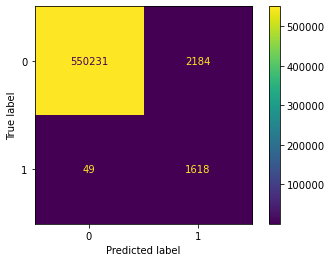

In [29]:
test_model(cad,X_res_train3,X_test6, y_res_train3,y_test6)

In [48]:
predictions_cad_Tomek=cad.predict(X_test6)

In [49]:
métriques(predictions_cad_Tomek,y_test6)

f1 score= 0.5916986652038764
precision= 0.42556549184639664
recall= 0.9706058788242351


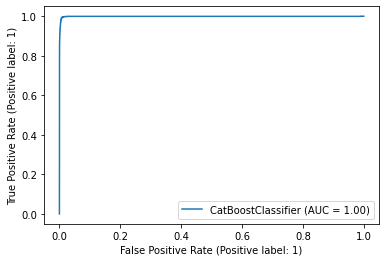

In [55]:
plot_roc_curve(cad,X_test6,y_test6)

**voisins**

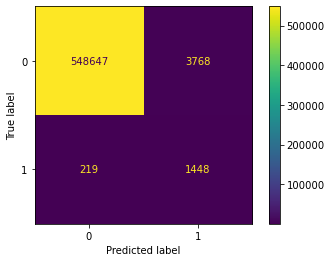

In [113]:
test_model(voisins,X_res_train3,X_test6, y_res_train3,y_test6)

In [114]:
predictions_voisins_Tomek=voisins.predict(X_test6)

In [115]:
métriques(predictions_voisins_Tomek,y_test6)

f1 score= 0.420746767397937
precision= 0.2776073619631902
recall= 0.8686262747450509


**adaboost**

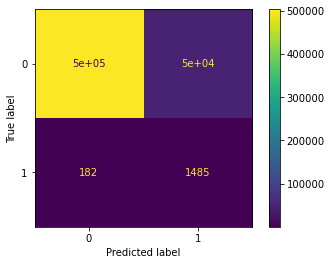

In [116]:
test_model(ADAboost,X_res_train3,X_test6, y_res_train3,y_test6)

In [117]:
predictions_ADA_Tomek=ADAboost.predict(X_test6)

In [118]:
métriques(predictions_ADA_Tomek,y_test6)

f1 score= 0.05632040050062579
precision= 0.029079444651144575
recall= 0.8908218356328734


**regression logistique**

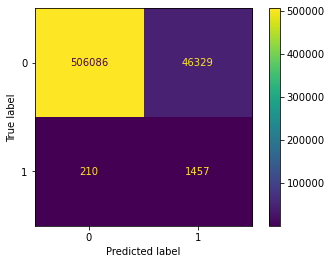

In [119]:
test_model(logistique,X_res_train3,X_test6, y_res_train3,y_test6)

In [120]:
predictions_logistique_Tomek=ADAboost.predict(X_test6)

In [121]:
métriques(predictions_logistique_Tomek,y_test6)

f1 score= 0.05632040050062579
precision= 0.029079444651144575
recall= 0.8908218356328734


**arbre de decision**

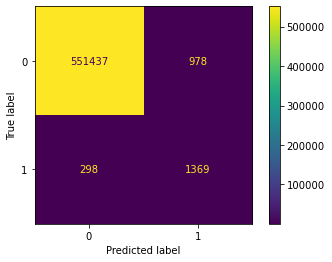

In [122]:
test_model(arbre,X_res_train3,X_test6, y_res_train3,y_test6)

In [123]:
predictions_arbre_Tomek=arbre.predict(X_test6)

In [124]:
métriques(predictions_arbre_Tomek,y_test6)

f1 score= 0.682112605879422
precision= 0.5832978270132083
recall= 0.8212357528494301


**gradientboosting**

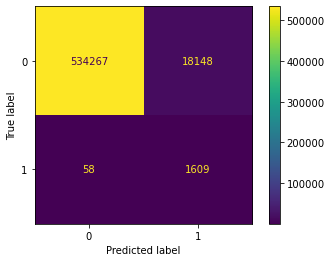

In [125]:
test_model(gradientboosting,X_res_train3,X_test6, y_res_train3,y_test6)

In [126]:
predictions_gradient_Tomek=gradientboosting.predict(X_test6)

In [127]:
métriques(predictions_gradient_Tomek,y_test6)

f1 score= 0.15020537714712473
precision= 0.08143948980108316
recall= 0.9652069586082783


**extratreeclassifier**

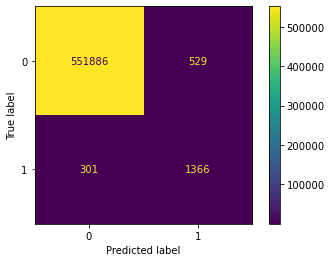

In [128]:
test_model(extreme_tree,X_res_train3,X_test6, y_res_train3,y_test6)

In [129]:
predictions_extree_Tomek=extreme_tree.predict(X_test6)

In [130]:
métriques(predictions_extree_Tomek,y_test6)

f1 score= 0.7669848399775407
precision= 0.720844327176781
recall= 0.8194361127774445


# Récapitulatifs de tout nos modèles

Au final, les modèles les plus prometteurs semblent être **Xgboosting** et **CATboosting**. Leurs performances sans SMOTE des données sont déja très satisfaisantes, le réequilibrage tend à faire baisser la précision au profit du recall. 

Avec un CATboosting et un SMOTE_Tomek, on obtient un recall de 0.971 et une précision de 0.423 ce qui est probablement notre meilleur compromis précision/rappel.

Pour la phase d'optimisation, nous allons nous intérésser plus en détails aux modèles **CATboosting** et **Xgboosting** ( et peut-être aussi à **randomforest** et **extratreeclassifier**